# Semi-supervised learning with Gradient Descent and Block Coordinate Gradient Descent <a class="tocSkip">

## Introduction

The intent behind this project is to preform semi-supervised learning tasks using Gradient Descent Methods on the loss function

$$
\min_{y \in{L}} f(y) = \sum_{i=0}^l\sum_{j=0}^u w_{ij}\left(y^j -\bar{y}^i\right)^2 + \frac{1}{2} \sum_{i=0}^u\sum_{j=0}^u \bar{w}_{ij}\left(y^j -y^i\right)^2
$$

The algorithms that will be used are:
* Gradient Descent
* Block Coordinate Gradient Descent with Randomized rule
* Block Coordinate Gradient Descent with Gauss-Southwell scheme

This approaches will be tested first on a randomly generated dataset where only a few observations will be labeled, and then on a publicly available dataset.

## Configuration

### Library Imports

In [1]:
# Import algebric manipulation packages
import numpy as np

# Import timer packages
import time
from timeit import default_timer as timer

# Import packages for generating synthethic data
from sklearn.datasets import make_blobs

# Import packages for data visualization
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Import dataset processing packages
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

### Global Variables

 - `NPOINTS`: total number of points to generate (each class will be the size of half of this number)
 - `LABELED_PERCENTAGE`: percentage of points that are going to be labeled in the synthetic dataset
 - `EPSILON`: optimality tolerance
 - `MAXNITERATIONS`: maximum number of iterations

In [2]:
NPOINTS = 2000
LABELED_PERCENTAGE = 0.1
EPSILON = 1.0e-3
MAXNITERATIONS = 100

In [3]:
NUNLABELED = int(NPOINTS * (1-LABELED_PERCENTAGE))

### Random seed
We will set a global random seed for reproducibility when randomly generating samples.

In [4]:
np.random.seed(42)

### Matplotlib configuration


In [5]:
# Set plots size
plt.rcParams['figure.figsize'] = [6.0, 6.0]
plt.rcParams['figure.dpi'] = 100

### Formulation of the Problem

Using the Gradient Descent Methods, our goal will be to minimize the loss function.

$$
\min_{y \in{L}} f(y) = \sum_{i=0}^l\sum_{j=0}^u w_{ij}\left(y^j -\bar{y}^i\right)^2 + \frac{1}{2} \sum_{i=0}^u\sum_{j=0}^u \bar{w}_{ij}\left(y^j -y^i\right)^2
$$

where:

* L - set of possible labels
* $\bar{y}^i$ - label of labeled sample i
* $y^j$ - label of unlabeled sample j
* $w_{ij}$ - similarity between labeled sample i and unlabeled sample j
* $\bar{w}_{ij}$ - similarity between unlabeled samples i and j

In [6]:
def loss_fn(labeled_y, unlabeled_y, weight_labeled_unlabeled, weight_unlabeled_unlabeled):
    
    #Expand dimensions for following matrix operations
    y = np.expand_dims(labeled_y,axis=1) #labeled points - y
    y_bar = np.expand_dims(unlabeled_y,axis=1) #unlabeled points - y predicted   
    
    #Term 1 - Sum of squared Differences between combinations of labeled and unlabeled points 
    #multiplied with its respective weight
    y_y_bar_sq_diff = np.power(y - y_bar.T, 2)
    y_y_bar_loss_term = np.sum(y_y_bar_sq_diff * weight_labeled_unlabeled)
        
    #Term 2 - Sum of squared Differences between combinations of unlabeled and unlabeled points 
    #multiplied with its respective weight
    y_bar_y_bar_sq_diff = np.power(y_bar - y_bar.T, 2)
    y_bar_y_bar_loss_term = np.sum(y_bar_y_bar_sq_diff * weight_unlabeled_unlabeled)

    total_loss = y_y_bar_loss_term + y_bar_y_bar_loss_term/2
    
    return total_loss

### Similarity function and weights

The similarity function used to obtain the weights will be of the type:

$$
similarity(a,b) = \frac{1}{1 + C||a-b||^p_2}
$$

In this case, we set $C = 1000$ and $p = 3$.

In [7]:
def similarity(dist):
    return 1/ (1 + 1000 * abs(dist) ** 3)

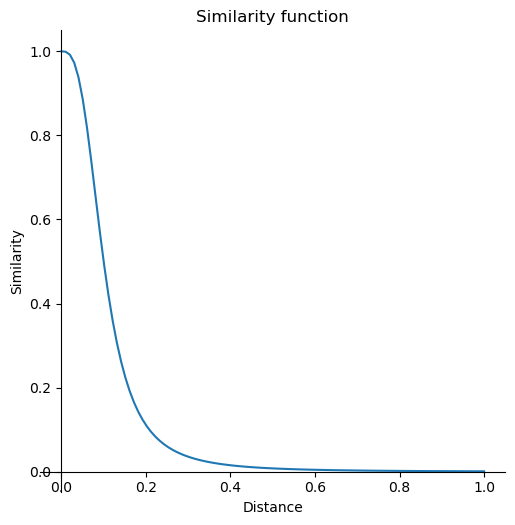

In [8]:
# Plotting the similarity function (similarity over distance)
x = np.linspace(0, 1, 100)
plt.xlabel('Distance')
plt.ylabel('Similarity')
plt.title("Similarity function")
ax = plt.gca()
ax.spines['top'].set_color('none')
ax.spines['bottom'].set_position('zero')
ax.spines['left'].set_position('zero')
ax.spines['right'].set_color('none')
ax.plot(x, similarity(x))
del x

Given two vectors of points, this function will return the matrix that contains the weight score between each pair of points.

In [9]:
def weight(x_1,x_2):
    """
    input: two vectors x_1 and x_2
    output: similarity between x_1 and x_2
    """
    
    # Calculate the euclidean distance between every pair of points
    distance_vector = np.linalg.norm(x_1[:, np.newaxis, :] - x_2[np.newaxis, :, :], axis=2)

    return similarity(distance_vector)

### Accuracy function

We will need this function to determine the accuracy of our method throughout its iterations.

In [10]:
def accuracy_approximation(y, y_target):
    """
    input: two vectors y (current iteration) and y_target
    output: accuracy of y
    """
    
    # Using sign function to predict the labels
    y_pred = np.sign(y)
    
    return sum(y_pred == y_target) / len(y_target)

### Plots helper functions

In [11]:
def plot_results(y, gd_method):
    """
    input: vector y (last iteration) and string gd_method (name of the Gradient Descent method)
    """
    
    # Predict label of each point of y
    y_pred = np.sign(y)
    
    # Plot labels outcome
    plt.title(f"Labels outcome using {gd_method}")
    plt.scatter([p[0] for p in x_unlabeled[y_pred == 1]], [p[1] for p in x_unlabeled[y_pred == 1]], c='blue')
    plt.scatter([p[0] for p in x_unlabeled[y_pred == -1]], [p[1] for p in x_unlabeled[y_pred == -1]], c='red')
    plt.xlabel("x1")
    plt.ylabel("x2")
    plt.legend(["1" , "-1"])
    plt.show()

In [12]:
def plot_accuracy(accuracy, gd_method, n_iterations):
    """
    input: accuracy vector, string gd_method (name of the Gradient Descent method) 
           and n_iterations (iteration # for each accuracy value)
    """
    
    # Plot accuracy vs iterations for the specified method
    plt.title(f"{gd_method} - Accuracy")
    plt.plot(n_iterations, accuracy)
    plt.xlabel("Iteration #")
    plt.ylabel("Accuracy (%)")
    plt.show()

In [13]:
def plot_loss(loss, gd_method, n_iterations):
    """
    input: accuracy vector, string gd_method (name of the Gradient Descent method) 
           and n_iterations (iteration # for each accuracy value)
    """
    
    # Plot loss vs iterations for the specified method
    plt.title(f"{gd_method} - Loss")
    plt.plot(n_iterations, loss)
    plt.xlabel("Iteration #")
    plt.ylabel("Loss")
    plt.show()

In [14]:
def build_predictions_df_boxplot(y_pred,y_target, gd_method):
    
    y_pred_minusone = y_pred[y_target==-1]
    y_target_minusone = np.ones(y_pred_minusone.shape) * (-1)
    concat_y_minusone = np.vstack((y_pred_minusone, y_target_minusone)).T
 
    y_pred_one = y_pred[y_target==1]
    y_target_one = np.ones(y_pred_one.shape) 
    concat_y_one = np.vstack((y_pred_one, y_target_one)).T
    
    df = pd.DataFrame(np.vstack((concat_y_minusone,concat_y_one)))
    df.columns = ["prediction", "target"]
    df["gd_method"] = gd_method
    df = df.drop(df[(df.prediction < -1) | (df.prediction > 1)].index)
    return df

## Methods Definition

### Gradient Descent Method

#### $L$ and $\sigma$

To accelerate our algorithm, we will try to obtain an optimal fixed stepsize,

$$
\alpha_k = \frac{2}{L+\sigma}.
$$

For this, we need to compute the Hessian matrix of the loss function:
    

In [15]:
def hessian(w_labeled_unlabeled, w_unlabeled_unlabeled):
    """
    input: weight matrix for labeled and unlabeled points,
           weight matrix for unlabeled points
    output: hessian of the loss function
    """
    
    # Initialize the hessian matrix
    hessian = np.zeros((NUNLABELED,NUNLABELED))
    
    for j in range(NUNLABELED):
        for k in range(NUNLABELED):
            if j == k:
                # Compute the diagonal elements
                hessian[j][k] = 2 * (sum(w_labeled_unlabeled[:,j]) + sum(w_unlabeled_unlabeled[:,j]) - w_unlabeled_unlabeled[j][j])
            else:
                # Compute the off-diagonal elements
                hessian[j][k] = - 2 * w_unlabeled_unlabeled[j][k]
    return hessian

Because the hessian matrix is symmetric, we're going to use `numpy.linalg.eigvalsh` to get it's eigenvalues. From these, we'll attribute the biggest eigenvalue to $L$ and the smallest, if strictly positive, to $\sigma$.

In [16]:
def L_sigma(hessian):
    """
    input: hessian matrix of the loss function
    output: L and sigma values
    """
    
    # Get the highest eigenvalue of the hessian for L
    L = np.linalg.eigvalsh(hessian)[-1]
    
    # Get the smallest eigenvalue of the hessian for sigma
    sigma = np.linalg.eigvalsh(hessian)[0]
    
    return L, sigma

In [17]:
def get_stepsize(L, sigma):
    """
    input: L and sigma values 
    output: stepsize
    """
    
    # Check if the function is sigma-strongly convex
    if sigma > 0 :
        stepsize = 2/(sigma + L)
    else:
        stepsize = 1/L
        
    return stepsize

#### Gradient Descent

To obtain the gradient for each iteration, we need to compute:
$$
\begin{align*}
\nabla_{y^j}f(y_k) &= 2 \sum_{i=0}^l w_{ij} \left( y_k^j - \bar{y}^i \right) + 2 \sum_{i=0}^u \bar{w}_{ij} \left( y_k^j - y_k^i \right) \\
& = 2 \left( \sum_{i=0}^l w_{ij} y_k^j - \sum_{i=0}^l w_{ij} \bar{y}^i + \sum_{i=0}^u \bar{w}_{ij} y_k^j - \sum_{i=0}^u \bar{w}_{ij} y_k^i\right) \\
& = 2 \left[ \left( \sum_{i=0}^l w_{ij} + \sum_{i=0}^u \bar{w}_{ij} \right) y_k^j - \sum_{i=0}^l w_{ij} \bar{y}^i  - \sum_{i=0}^u \bar{w}_{ij} y_k^i\right] \\
\end{align*}
$$

The values that will be computed solely using the weights matrices or the vector of the labeled samples can be computed prior to the gradient iterations, because these will remain constant trough time (they don't depend on $k$).

In [18]:
def gradient_descent(y_initial, y_labeled, y_unlabeled,
                     w_labeled_unlabeled, w_unlabeled_unlabeled,
                     hessian):
    """
    input: initial iterate, vector of labeled points, vector of unlabeled points,
           weight matrix between labeled and unlabeled points, weight matrix for unlabeled points,
           hessian matrix of the loss function
    output: last iterate of the method, accuracy vector, loss vector, run time vector and iterations vector
    """
    
    # Calculating the sum of the weights between the labeled and unlabeled points and the weights between the unlabeled points
    coeff_j = np.sum(w_labeled_unlabeled, axis=0) + np.sum(w_unlabeled_unlabeled, axis=0)
    
    # Calculating the dot product of the transposed matrix of the weights between the labeled and unlabeled points 
    # and the target of the labeled points
    term_2 = np.dot(w_labeled_unlabeled.T, y_labeled)
    
    loss = []
    acc = []
    run_time = []
    iterations = []
    
    y = np.copy(y_initial)
    
    # Getting L, sigma and stepsize
    L, sigma = L_sigma(hessian)
    stepsize = get_stepsize(L, sigma)
    
    print(f"GRADIENT DESCENT - Maximum Iterations: {MAXNITERATIONS}", end="\n")
    print("----------------------------------------------------------------------")
    
    gd_start = timer()

    for i in range(MAXNITERATIONS):
        
        # Calculating the gradient
        grad = 2 * (coeff_j * y - term_2 - np.dot(w_unlabeled_unlabeled.T, y))

        if np.sqrt(2 * sigma * EPSILON) >= np.linalg.norm(grad):
            print("Optimality tolerance condition met.\n")
            print(f"Iteration: {i+1} -> Loss: {loss[-1]:.4f} , Accuracy approximation: {100*accuracy:.2f}%",end="\n")
            break  
        
        # Updating the loss function in each iteration
        y = y - stepsize * grad 
        
        loss_value = loss_fn(y_labeled, y, w_labeled_unlabeled, w_unlabeled_unlabeled)
        accuracy = accuracy_approximation(y, y_unlabeled)
       
        gd_iter_end = timer()

        acc.append(accuracy)
        loss.append(loss_value)
        run_time.append(gd_iter_end - gd_start)
        
        if i == 0 or (i + 1) % 10 == 0:
            print(f"Iteration: {i+1} -> Loss: {loss_value:.4f}, Accuracy approximation: {100*accuracy:.2f}%",end="\n")
    
        iterations.append(i)
        
    return y, acc, loss, run_time, iterations

### Block Coordinate Gradient Methods

For this approach, we choose one block at a time and calculate the derivative with respect to this block.

To get optimal convergence results, we need to calculate $L_i$, the Lipschitz constants of the gradient components with respect to the $i$-th coordinate of the loss function.

In the case of 1-sized blocks, $L_i$ is given by the diagonal entry of the Hessian matrix corresponding to the $i$-th coordinate.

In [19]:
def get_Li(hessian):
    """
    input: hessian matrix of the loss function
    output: diagonal of the hessian
    """
    return hessian.diagonal()

#### Randomized Gradient Descent Method

We use the following probability function to choose the coordinate $i$ in each iterate:
$$
P\left(i_k = i\right) = \frac{L_i}{\sum_{i=1}^b{L_i}} .
$$

In [20]:
def bcgd_randomized(y_initial, y_labeled, y_unlabeled,
                    w_labeled_unlabeled, w_unlabeled_unlabeled,
                    hessian):
    """
    input: initial iterate, vector of labeled points, vector of unlabeled points,
           weight matrix between labeled and unlabeled points, weight matrix for unlabeled points,
           hessian matrix of the loss function
    output: last iterate of the method, accuracy vector, loss vector, run time vector and iterations vector
    """
    
    # Calculating the sum of the weights between the labeled and unlabeled points and the weights between the unlabeled points
    coeff_j = np.sum(w_labeled_unlabeled, axis=0) + np.sum(w_unlabeled_unlabeled, axis=0)
    
    # Calculating the dot product of the transposed matrix of the weights between the labeled and unlabeled points 
    # and the target of the labeled points
    term_2 = np.dot(w_labeled_unlabeled.T, y_labeled)
    
    loss = []
    acc = []
    run_time = []
    iterations = []
    
    y = np.copy(y_initial)
    previous_loss = loss_fn(y_labeled, y, w_labeled_unlabeled, w_unlabeled_unlabeled)
    delta_min = 1e-4 * previous_loss

    rgdm_iterations = MAXNITERATIONS * len(y) 
    
    # Get L_i vector
    L_i = get_Li(hessian)
    
    # Get probability vector for choosing each respective coordinate
    probabilities = L_i/sum(L_i)
    
    print(f"RANDOMIZED GRADIENT DESCENT - Iterations: {rgdm_iterations}", end = "\n")
    print("----------------------------------------------------------------------")
    
    rgdm_start = timer()
    
    for i in range(rgdm_iterations):
        
        idx = np.random.choice([*range(len(y))], p = probabilities)

        # Calculating the gradient
        grad = 2 * (coeff_j[idx] * y[idx] - term_2[idx] - np.dot(w_unlabeled_unlabeled[:,idx], y.T))

        stepsize = 1/L_i[idx]
        
        # Updating the loss function in each iteration
        y[idx] = y[idx] - stepsize * grad
        
        if i == 0 or ((i + 1) % (0.05 * rgdm_iterations)) == 0:
            
            loss_value = loss_fn(y_labeled, y, w_labeled_unlabeled, w_unlabeled_unlabeled)
            accuracy = accuracy_approximation(y, y_unlabeled)
            
            delta_f = abs(loss_value - previous_loss)
            
            if i != 0 and delta_f < delta_min:
                print(f"Iteration: {i+1} -> Loss: {loss_value:.4f}, Accuracy approximation: {100*accuracy:.2f}%",end="\n")
                print('Stopping algorithm because of insignificant improvement in the loss.')
                break
            
            acc.append(accuracy)
            loss.append(loss_value)
            rgdm_iter_end = timer()
            run_time.append(rgdm_iter_end - rgdm_start)
            
            print(f"Iteration: {i+1} -> Loss: {loss_value:.4f}, Accuracy approximation: {100*accuracy:.2f}%",end="\n")
            
            previous_loss = loss_value
            
            iterations.append(i+1)

    return y, acc, loss, run_time, iterations

#### Gauss-Southwell

In [21]:
def bcgd_gauss_southwell(y_initial, y_labeled, y_unlabeled,
            w_labeled_unlabeled, w_unlabeled_unlabeled,
            hessian):
    
    # Calculating the sum of the weights between the labeled and unlabeled points and the weights between the unlabeled points
    coeff_j = np.sum(w_labeled_unlabeled, axis=0) + np.sum(w_unlabeled_unlabeled, axis=0)
    
    # Calculating the dot product of the transposed matrix of the weights between the labeled and unlabeled points 
    # and the target of the labeled points
    term_2 = np.dot(w_labeled_unlabeled.T, y_labeled)
    
    loss = []
    acc = []
    run_time = []
    iterations = []
    
    y = np.copy(y_initial)
    previous_loss = loss_fn(y_labeled, y, w_labeled_unlabeled, w_unlabeled_unlabeled)
    delta_min = 1e-4 * previous_loss
    
    gsdm_iterations = MAXNITERATIONS * len(y)
    
    # Get L_i vector
    L_i = get_Li(hessian)
    
    print(f"GAUSS-SOUTHWELL GRADIENT DESCENT - Iterations: {gsdm_iterations}", end="\n \n")
    print("----------------------------------------------------------------------")
    
    gsdm_start = timer()
    
    # Calculating the gradient
    grad = 2 * (coeff_j * y - term_2 - np.dot(w_unlabeled_unlabeled, y.T))
    
    for i in range(gsdm_iterations):
        
        idx = np.argmax(np.abs(grad))
        
        stepsize = 1/L_i[idx]
        
        step = - stepsize * grad[idx]
        
        # Updating the loss function in each iteration
        y[idx] = y[idx] + step
    
        # Updating gradient
        # In order to not call again the gradient method, we're reusing the previous gradient
        # but adding up the change in the y value represented by the previously computed step
        
        grad -= 2* w_unlabeled_unlabeled[idx] * step #third coeff update
        grad[idx] += 2 * coeff_j[idx] * step #first coeff update
        
    
        if i == 0 or ((i + 1) % (0.01 * gsdm_iterations)) == 0:
            
            loss_value = loss_fn(y_labeled, y, w_labeled_unlabeled, w_unlabeled_unlabeled)
            accuracy = accuracy_approximation(y, y_unlabeled)
            
            delta_f = abs(loss_value - previous_loss)
            
            if i!=0 and delta_f < delta_min:
                print(f"Iteration: {i+1} -> Loss: {loss_value:.4f}, Accuracy approximation: {100*accuracy:.2f}%",end="\n")
                print('Stopping algorithm because of insignificant improvement in the loss.')
                break
            
            acc.append(accuracy)
            loss.append(loss_value)
            gsdm_iter_end = timer()
            run_time.append(gsdm_iter_end - gsdm_start)
            
            print(f"Iteration: {i+1} -> Loss: {loss_value:.4f}, Accuracy approximation: {100*accuracy:.2f}%",end="\n")
            
            previous_loss = loss_value
            
            iterations.append(i+1)
            
    return y, acc, loss, run_time, iterations

## Synthetic Dataset

We will start by generating a 2D binary dataset, to each point will be attributed a label $-1$ or $1$.

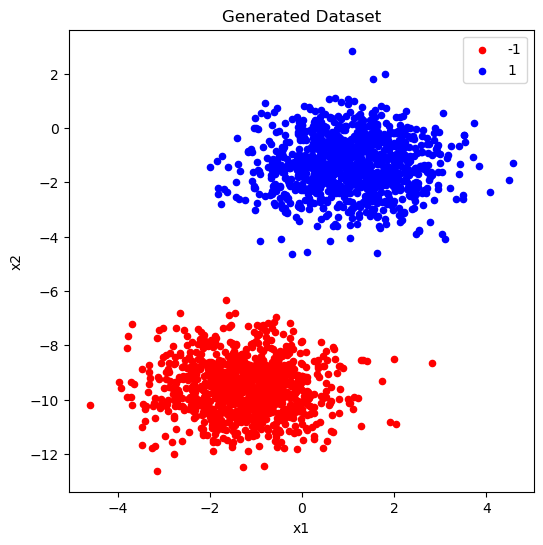

In [22]:
# Generate 2 clusters with labels 0 and 1
X, y = make_blobs(n_samples=NPOINTS, centers=2, n_features=2, random_state=2)

# Convert label 0 to -1
y[y==0] = -1

# Plot the generated dataset
df = pd.DataFrame(dict(x=X[:,0], y=X[:,1], label=y))
colors = {-1:'red', 1:'blue'}
fig, ax = plt.subplots()
grouped = df.groupby('label')
for key, group in grouped:
    group.plot(ax=ax, kind='scatter', x='x', y='y', label=key, color=colors[key])
plt.title('Generated Dataset')
plt.xlabel("x1")
plt.ylabel("x2")
plt.show()

### Data Preparation
To simulate a semi-supervised learning scenario, we will be selecting a subset of the labeled points to be used as unlabeled data.

In [23]:
samples = np.column_stack((X,y))

In [24]:
# Separate dataset by labels
samples_y0 = samples[samples[:,2] == -1]
samples_y1 = samples[samples[:,2] == 1]

In [25]:
# Get unlabeled samples from class -1
idx_unlabeled_y0 = np.random.choice(samples_y0.shape[0],int((1 - LABELED_PERCENTAGE) * samples_y0.shape[0])  , replace=False)
samples_y0_unlabeled = samples_y0[idx_unlabeled_y0, :]
samples_y0_labeled = np.delete(samples_y0, idx_unlabeled_y0, axis=0)

In [26]:
# Get unlabeled samples from class 1
idx_unlabeled_y1 = np.random.choice(samples_y1.shape[0],int((1 - LABELED_PERCENTAGE) * samples_y0.shape[0])  , replace=False)
samples_y1_unlabeled = samples_y1[idx_unlabeled_y1, :]
samples_y1_labeled = np.delete(samples_y1, idx_unlabeled_y1, axis=0)

In [27]:
x_unlabeled = np.concatenate((samples_y0_unlabeled[:,:2], samples_y1_unlabeled[:,:2]))
x_labeled =  np.concatenate((samples_y0_labeled[:,:2], samples_y1_labeled[:,:2]))
y_labeled =  np.concatenate((samples_y0_labeled[:,2], samples_y1_labeled[:,2]))
y_unlabeled_target =  np.concatenate((samples_y0_unlabeled[:,2], samples_y1_unlabeled[:,2]))

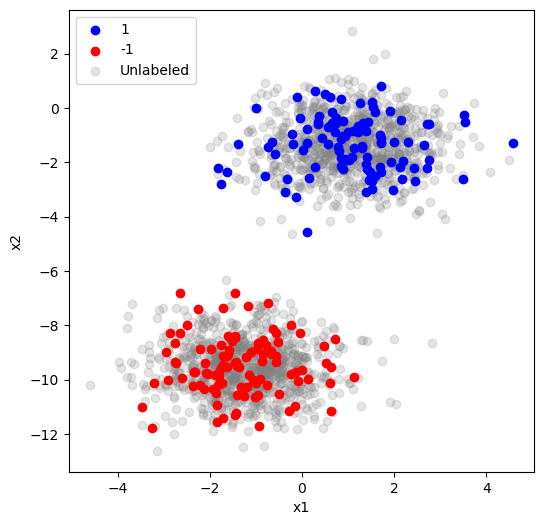

In [28]:
# Plot labeled vs unlabeled points
u_0 = plt.scatter(samples_y0_unlabeled[:,0],samples_y0_unlabeled[:,1], c ="grey", alpha = 0.2)
l_0 = plt.scatter(samples_y0_labeled[:,0],samples_y0_labeled[:,1], c="red")
u_1 = plt.scatter(samples_y1_unlabeled[:,0],samples_y1_unlabeled[:,1], c="grey", alpha = 0.2)
l_1 = plt.scatter(samples_y1_labeled[:,0],samples_y1_labeled[:,1], c ="blue")
plt.legend((l_1, l_0, u_0, u_1), ( '1', '-1', 'Unlabeled'), loc='upper left')
plt.xlabel("x1")
plt.ylabel("x2")
plt.show()

### Weights assignment and Hessian matrix

Now, we can assign weights to the points generated.

In [29]:
w_labeled_unlabeled = weight(x_labeled, x_unlabeled)
w_unlabeled_unlabeled = weight(x_unlabeled, x_unlabeled)

In [30]:
hessian_matrix = hessian(w_labeled_unlabeled, w_unlabeled_unlabeled)

### Initial vector $y$

Initialization of the labels to random values between $-1$ and $1$.
This vector is the one that's gonna be used in all three methods as a starting point.

In [31]:
unlabeled_number = int(NPOINTS * (1-LABELED_PERCENTAGE))
y_initial = np.random.choice([-1, 1], size=(unlabeled_number,)).astype("float64")

### Gradient Descent

In [32]:
%%time

gd = gradient_descent(y_initial, y_labeled, y_unlabeled_target, 
                      w_labeled_unlabeled, w_unlabeled_unlabeled,
                      hessian_matrix)

GRADIENT DESCENT - Maximum Iterations: 100
----------------------------------------------------------------------
Iteration: 1 -> Loss: 2562.2045, Accuracy approximation: 55.28%
Iteration: 10 -> Loss: 292.4174, Accuracy approximation: 93.28%
Iteration: 20 -> Loss: 122.4766, Accuracy approximation: 96.67%
Iteration: 30 -> Loss: 69.2365, Accuracy approximation: 98.22%
Iteration: 40 -> Loss: 47.2475, Accuracy approximation: 98.56%
Iteration: 50 -> Loss: 36.5624, Accuracy approximation: 98.78%
Iteration: 60 -> Loss: 30.6805, Accuracy approximation: 99.06%
Iteration: 70 -> Loss: 27.0887, Accuracy approximation: 99.11%
Iteration: 80 -> Loss: 24.6926, Accuracy approximation: 99.33%
Iteration: 90 -> Loss: 22.9700, Accuracy approximation: 99.56%
Iteration: 100 -> Loss: 21.6524, Accuracy approximation: 99.56%
CPU times: total: 21.2 s
Wall time: 17.1 s


In [33]:
prediction_gd = gd[0]
accuracy_gd = gd[1]
loss_gd = gd[2]
run_time_gd = gd[3]
iterations_gd = gd[4]

gd_method = "Gradient Descent"

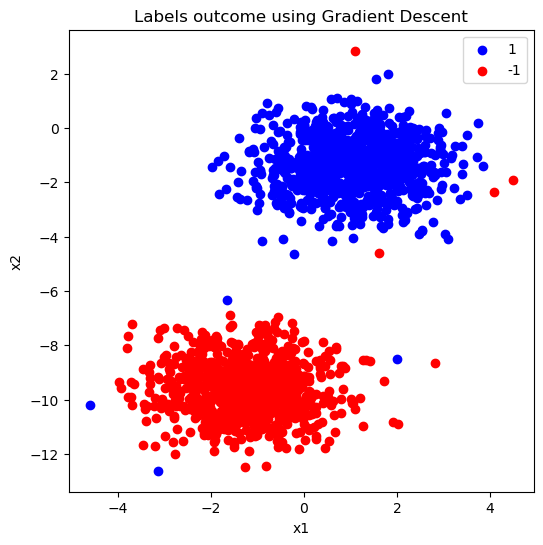

In [34]:
plot_results(prediction_gd, gd_method)

In [35]:
# Number of points misclassified
np.sum(np.sign(prediction_gd) != y_unlabeled_target)

8

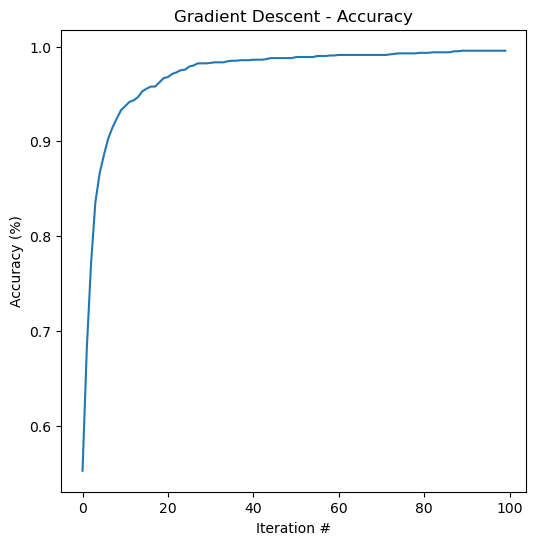

In [36]:
plot_accuracy(accuracy_gd, gd_method,iterations_gd)

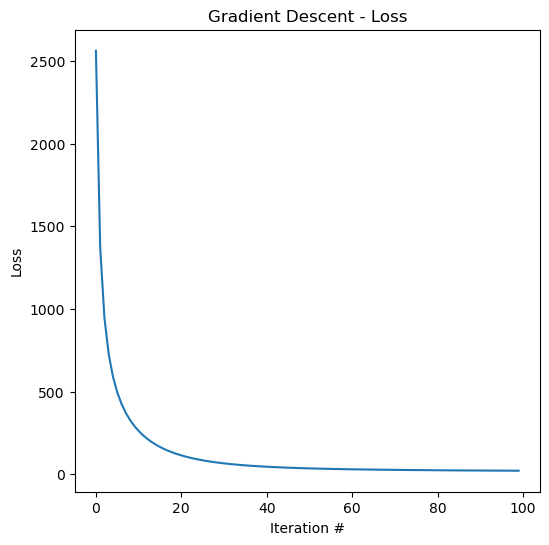

In [37]:
plot_loss(loss_gd, gd_method, iterations_gd)

In [38]:
del gd_method

### BCGD with Randomized Rule

In [39]:
%%time

bcgd_rr = bcgd_randomized(y_initial, y_labeled, y_unlabeled_target, 
                          w_labeled_unlabeled, w_unlabeled_unlabeled, 
                          hessian_matrix)

RANDOMIZED GRADIENT DESCENT - Iterations: 180000
----------------------------------------------------------------------
Iteration: 1 -> Loss: 11276.9530, Accuracy approximation: 50.06%
Iteration: 9000 -> Loss: 558.2220, Accuracy approximation: 90.11%
Iteration: 18000 -> Loss: 221.1541, Accuracy approximation: 95.11%
Iteration: 27000 -> Loss: 106.9092, Accuracy approximation: 97.11%
Iteration: 36000 -> Loss: 67.9872, Accuracy approximation: 97.78%
Iteration: 45000 -> Loss: 47.6788, Accuracy approximation: 98.11%
Iteration: 54000 -> Loss: 33.5461, Accuracy approximation: 98.56%
Iteration: 63000 -> Loss: 25.2013, Accuracy approximation: 98.94%
Iteration: 72000 -> Loss: 21.7000, Accuracy approximation: 99.06%
Iteration: 81000 -> Loss: 18.3740, Accuracy approximation: 99.17%
Iteration: 90000 -> Loss: 16.0031, Accuracy approximation: 99.22%
Iteration: 99000 -> Loss: 13.2878, Accuracy approximation: 99.33%
Iteration: 108000 -> Loss: 12.1793, Accuracy approximation: 99.44%
Stopping algorithm b

In [40]:
prediction_rr = bcgd_rr[0]
accuracy_rr = bcgd_rr[1]
loss_rr = bcgd_rr[2]
run_time_rr = bcgd_rr[3]
iterations_rr = bcgd_rr[4]

gd_method = "Block Coordinate Gradient Descent with Randomized Rule"

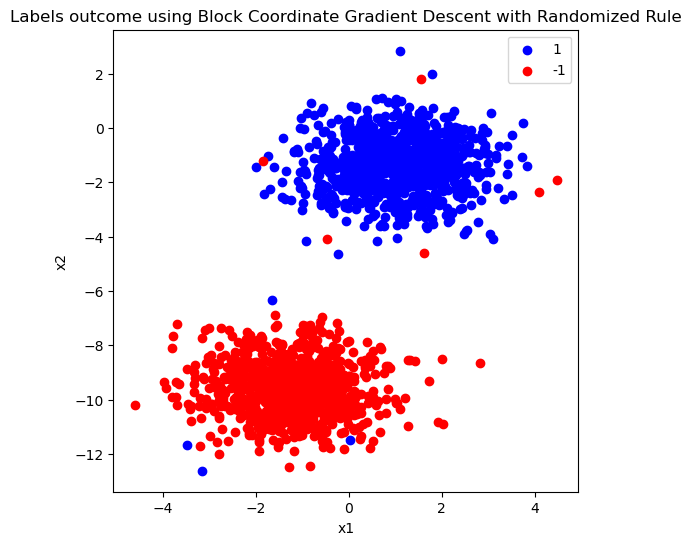

In [41]:
plot_results(prediction_rr, gd_method)

In [42]:
# Number of points misclassified
np.sum(np.sign(prediction_rr) != y_unlabeled_target)

10

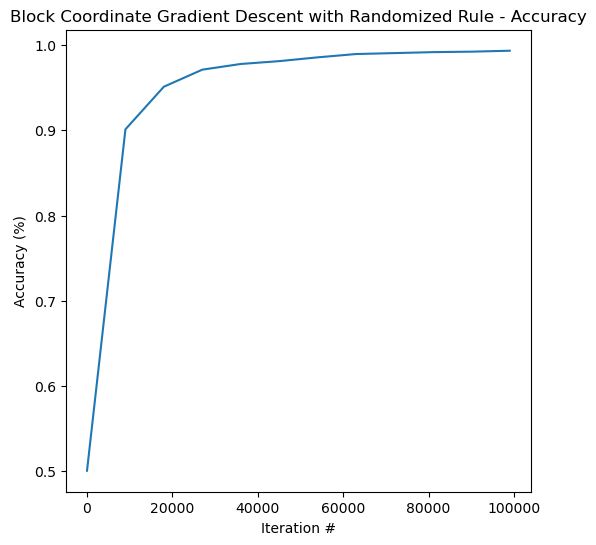

In [43]:
plot_accuracy(accuracy_rr, gd_method, iterations_rr)

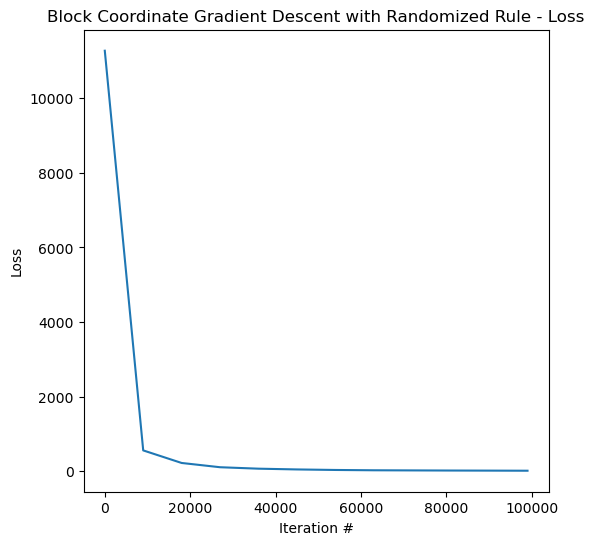

In [44]:
plot_loss(loss_rr, gd_method, iterations_rr)

In [45]:
del gd_method

### BCGD with Gauss-Southwell Scheme

In [46]:
%%time

bcgd_gs = bcgd_gauss_southwell(y_initial, y_labeled, y_unlabeled_target, 
                  w_labeled_unlabeled, w_unlabeled_unlabeled, 
                  hessian_matrix)

GAUSS-SOUTHWELL GRADIENT DESCENT - Iterations: 180000
 
----------------------------------------------------------------------
Iteration: 1 -> Loss: 11260.1608, Accuracy approximation: 50.11%
Iteration: 1800 -> Loss: 526.3636, Accuracy approximation: 89.89%
Iteration: 3600 -> Loss: 121.4526, Accuracy approximation: 97.61%
Iteration: 5400 -> Loss: 47.2660, Accuracy approximation: 98.83%
Iteration: 7200 -> Loss: 24.0586, Accuracy approximation: 99.11%
Iteration: 9000 -> Loss: 14.6141, Accuracy approximation: 99.67%
Iteration: 10800 -> Loss: 10.5199, Accuracy approximation: 99.89%
Iteration: 12600 -> Loss: 8.9086, Accuracy approximation: 99.94%
Iteration: 14400 -> Loss: 8.0962, Accuracy approximation: 100.00%
Stopping algorithm because of insignificant improvement in the loss.
CPU times: total: 1.55 s
Wall time: 1.73 s


In [47]:
prediction_gs = bcgd_gs[0]
accuracy_gs = bcgd_gs[1]
loss_gs = bcgd_gs[2]
run_time_gs = bcgd_gs[3]
iterations_gs = bcgd_gs[4]

gd_method = "Block Coordinate Gradient Descent with Gauss-Southwell Scheme"

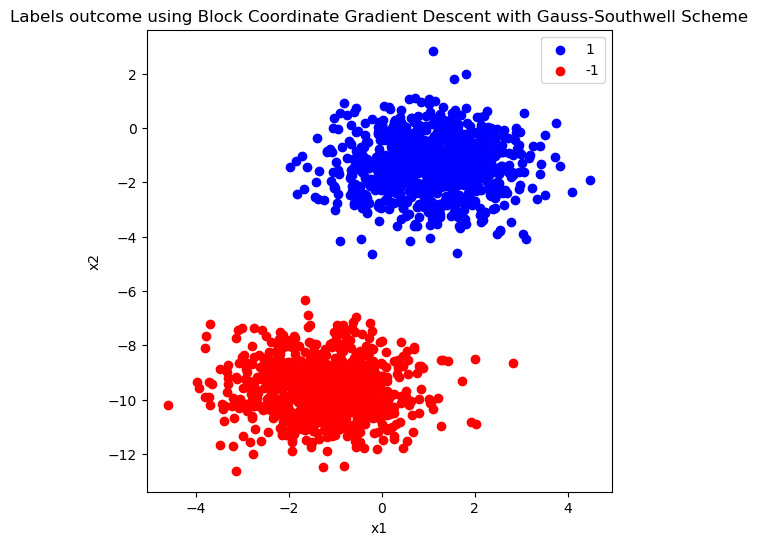

In [48]:
plot_results(prediction_gs, gd_method)

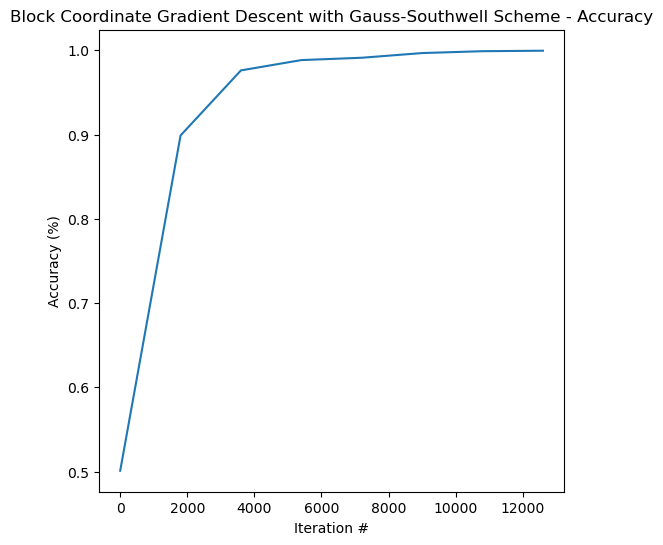

In [49]:
plot_accuracy(accuracy_gs, gd_method, iterations_gs)

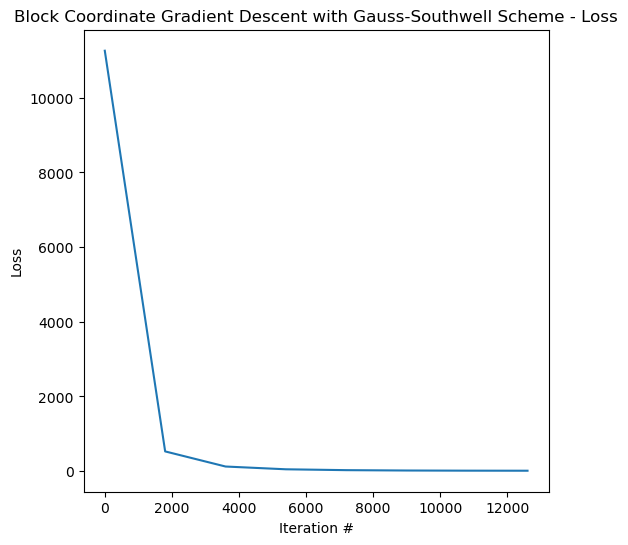

In [50]:
plot_loss(loss_gs, gd_method, iterations_gs)

In [51]:
del gd_method

### Comparison between Gradient methods

**To update** 
As we can see, the BCGM cyclic is the fastest, since using the Lipschitz constant for the single bloc, after one iteration (considered as one complete cycle over all the blocks) finds the best solution, followed by the BCGM random, which also exploits the Lipschitz fo the singe variable to have a better estimate of the stepsize.
In last position we find the Gradient Descent, which is slower due to the stepsize estimated using the Lipschitz constant of the whole problem, which is the highest eigenvalue, and therefore is just a "safe" upper bound

In [119]:
gd_methods = ['Gradient Descent',
        'BCGD with Randomized Rule',
        'BCGD Gauss-Southwell Scheme',
    ]

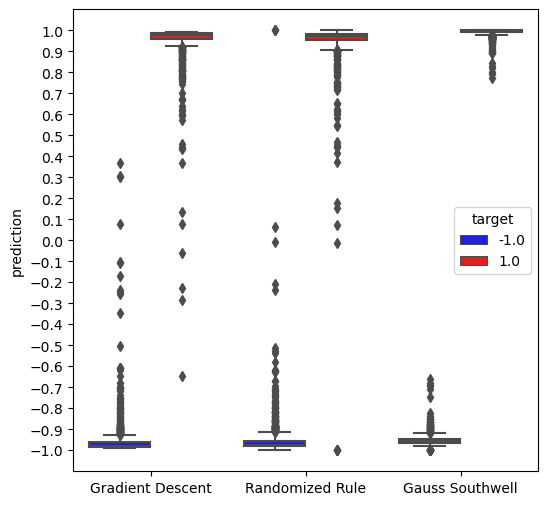

In [53]:
gd_pred = build_predictions_df_boxplot(prediction_gd, y_unlabeled_target, 'Gradient Descent')
rr_pred = build_predictions_df_boxplot(prediction_rr, y_unlabeled_target, 'Randomized Rule')
gs_pred = build_predictions_df_boxplot(prediction_gs, y_unlabeled_target, 'Gauss Southwell')

df_pred = pd.concat([gd_pred, rr_pred, gs_pred])
ax = sns.boxplot(x="gd_method", y="prediction",
            hue="target", palette=["b", "r"],data=df_pred)
ax.set_yticks(np.arange(-1,1.1,0.1))
ax.set(xlabel=None)

plt.show()

#### Accuracy

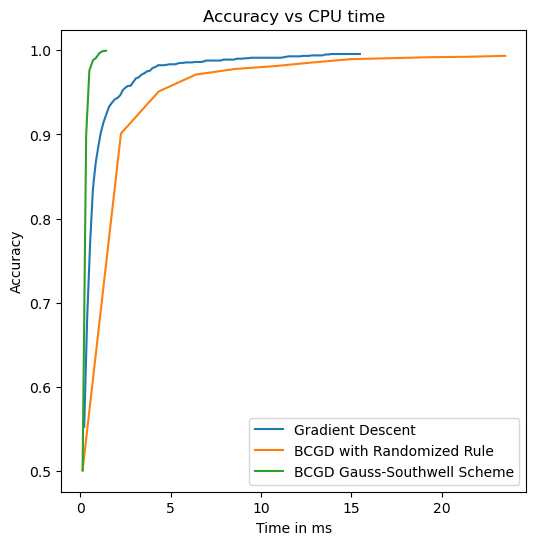

In [120]:
plt.plot(run_time_gd, accuracy_gd)
plt.plot(run_time_rr, accuracy_rr)
plt.plot(run_time_gs, accuracy_gs)

plt.title("Accuracy vs CPU time")
plt.xlabel("Time in ms")
plt.ylabel("Accuracy")
plt.legend(gd_methods)

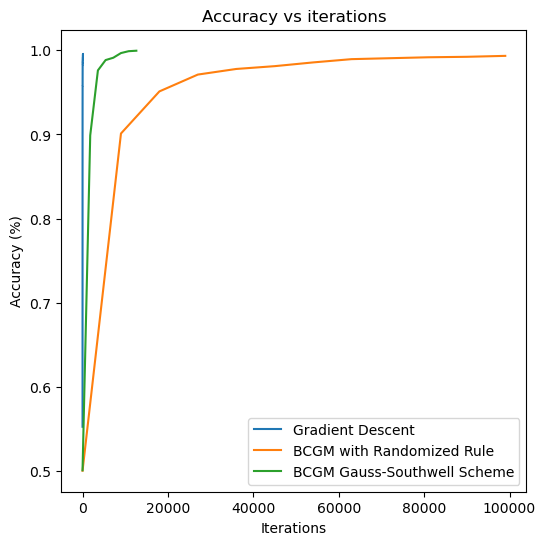

In [55]:
plt.plot(iterations_gd, accuracy_gd)
plt.plot(iterations_rr, accuracy_rr)
plt.plot(iterations_gs, accuracy_gs)
plt.title("Accuracy vs iterations")
plt.xlabel("Iterations")
plt.ylabel("Accuracy (%)")
plt.legend(gd_methods)

#### Loss

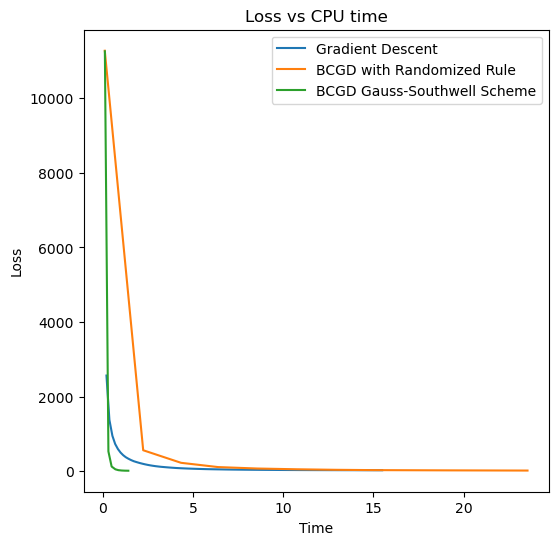

In [121]:
plt.plot(run_time_gd , loss_gd)
plt.plot(run_time_rr , loss_rr)
plt.plot(run_time_gs , loss_gs)

plt.title("Loss vs CPU time")
plt.xlabel("Time")
plt.ylabel("Loss")
plt.legend(gd_methods)

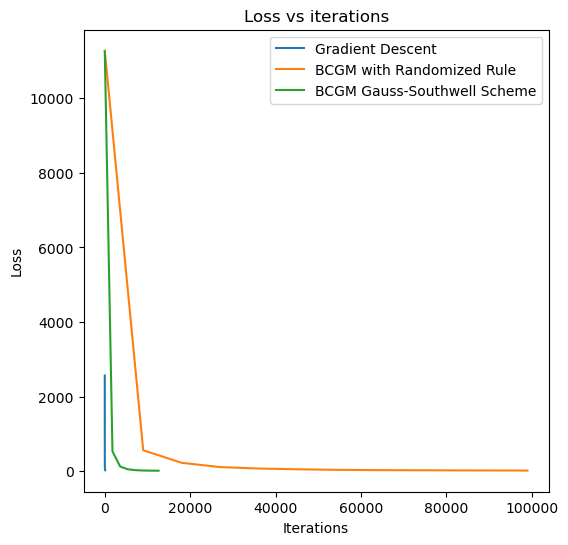

In [57]:
plt.plot(iterations_gd, loss_gd)
plt.plot(iterations_rr, loss_rr)
plt.plot(iterations_gs, loss_gs)

plt.title("Loss vs iterations")
plt.xlabel("Iterations")
plt.ylabel("Loss")
plt.legend(gd_methods)

## Breast Cancer Prediction Dataset

We would like to further test the accuracy of the methods above using another dataset taken from Kaggle. The data chosen represents 30 variables used to predict if breast tumors in 569 patients are malignant (cancerous) or benign (non-cancerous) under the target variable 'diagnosis'. 

In [58]:
# load the dataset
# "C:/Users/auria/Downloads/data.csv"
bc_url = "C:/Users/inesc/Downloads/data.csv"

In [59]:
bc_data = pd.read_csv(bc_url)
bc_df = pd.DataFrame(bc_data)

Once the dataset is downloaded, it is processed and cleaned.

In [60]:
bc_df['diagnosis'] = np.where(bc_df['diagnosis'] =="M", 1, bc_df['diagnosis'])
bc_df['diagnosis'] = np.where(bc_df['diagnosis'] =="B", -1, bc_df['diagnosis'])

col0 = bc_df.pop('diagnosis')
bc_df.insert(len(bc_df.columns)-1, 'diagnosis', col0)
bc_df = bc_df.iloc[:,1:32]

In [61]:
# Check for NAs
bc_df.isna().sum()

radius_mean                0
texture_mean               0
perimeter_mean             0
area_mean                  0
smoothness_mean            0
compactness_mean           0
concavity_mean             0
concave points_mean        0
symmetry_mean              0
fractal_dimension_mean     0
radius_se                  0
texture_se                 0
perimeter_se               0
area_se                    0
smoothness_se              0
compactness_se             0
concavity_se               0
concave points_se          0
symmetry_se                0
fractal_dimension_se       0
radius_worst               0
texture_worst              0
perimeter_worst            0
area_worst                 0
smoothness_worst           0
compactness_worst          0
concavity_worst            0
concave points_worst       0
symmetry_worst             0
fractal_dimension_worst    0
diagnosis                  0
dtype: int64

In [62]:
bc_df.head()

,radius_mean,texture_mean,perimeter_mean,area_mean,smoothness_mean,compactness_mean,concavity_mean,concave points_mean,symmetry_mean,fractal_dimension_mean,...,texture_worst,perimeter_worst,area_worst,smoothness_worst,compactness_worst,concavity_worst,concave points_worst,symmetry_worst,fractal_dimension_worst,diagnosis
0,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.3001,0.14710,0.2419,0.07871,...,17.33,184.60,2019.0,0.1622,0.6656,0.7119,0.2654,0.4601,0.11890,1
1,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.0869,0.07017,0.1812,0.05667,...,23.41,158.80,1956.0,0.1238,0.1866,0.2416,0.1860,0.2750,0.08902,1
2,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.1974,0.12790,0.2069,0.05999,...,25.53,152.50,1709.0,0.1444,0.4245,0.4504,0.2430,0.3613,0.08758,1
3,11.42,20.38,77.58,386.1,0.14250,0.28390,0.2414,0.10520,0.2597,0.09744,...,26.50,98.87,567.7,0.2098,0.8663,0.6869,0.2575,0.6638,0.17300,1
4,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.1980,0.10430,0.1809,0.05883,...,16.67,152.20,1575.0,0.1374,0.2050,0.4000,0.1625,0.2364,0.07678,1


### PCA

In order to reduce the dimentionality of our data, we will perform Principal Componenet Analysis (PCA) which will transform the data into components explaining most of the data variability.

First, the data is split into training and testing sets to then be standarized and fitted.


In [63]:
# Splitting the X and Y into the training set and testing set

X_bc = bc_df.iloc[:, 1:31]
y_bc = bc_df.diagnosis

X_train_bc, X_test_bc, y_train_bc, y_test_bc = train_test_split(X_bc, y_bc, test_size = 0.8, random_state = 0)

In [64]:
# Use Standard Scaler to standarize the data

std = StandardScaler()

X_train_std_bc = std.fit_transform(X_train_bc)
X_train_std_bc = pd.DataFrame(X_train_std_bc, columns=X_bc.columns)
X_test_std_bc = std.transform(X_test_bc)
X_test_std_bc = pd.DataFrame(X_test_std_bc, columns=X_bc.columns)

pca_bc = PCA().fit(X_train_std_bc)

The explained variance by each principal component is then plotted. We notice that the first six pricipal components explained 90% of the variance.


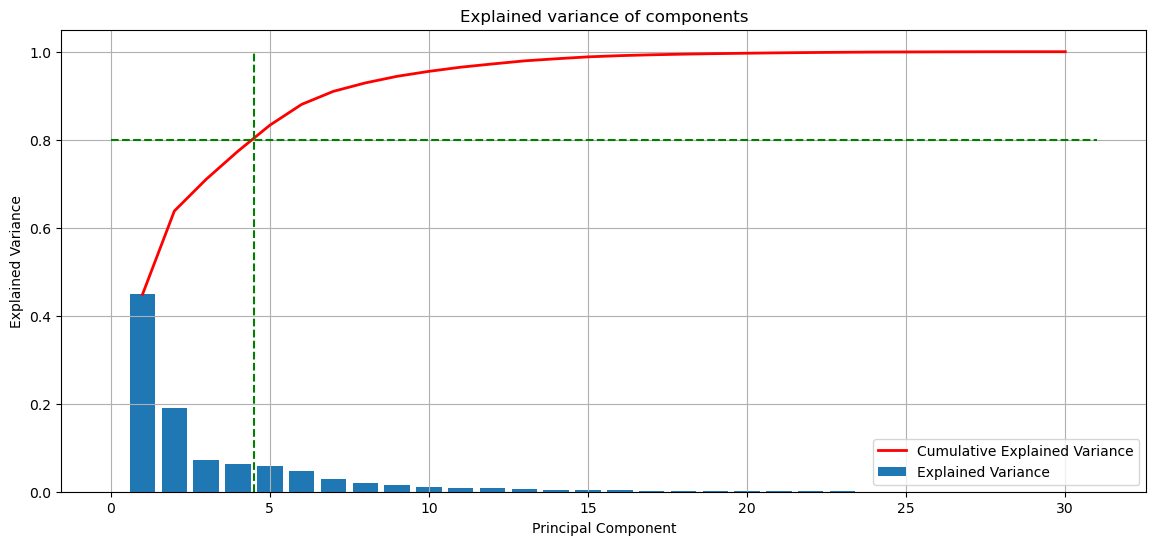

In [65]:
fig, ax = plt.subplots(figsize = (14,6))
x_values = range(1, pca_bc.n_components_+1)
ax.bar(x_values, pca_bc.explained_variance_ratio_, lw=2, label='Explained Variance')
ax.plot(x_values, np.cumsum(pca_bc.explained_variance_ratio_), lw=2, label='Cumulative Explained Variance', color='red')
plt.plot([0,pca_bc.n_components_+1], [0.80,0.80],'g--')
plt.plot([4.5,4.5],[0,1], 'g--')
ax.set_title('Explained variance of components')
ax.set_xlabel('Principal Component')
ax.set_ylabel('Explained Variance')
plt.grid()
plt.legend()
plt.show()

Since the first six components show the most variability, we reduce the dimensions and work on the newly transformed data.


In [66]:
pca_bc_4 = PCA(n_components=4).fit(X_train_std_bc) # use only first 4 principal components

# Transform the standardized training and testing data using the PCA object with only 6 components
X_train_pca_bc = pca_bc_4.transform(X_train_std_bc)
X_test_pca_bc = pca_bc_4.transform(X_test_std_bc)

### Gradient Descent

In [67]:
NUNLABELED = X_test_pca_bc.shape[0]
w_labeled_unlabeled_bc = weight(X_train_pca_bc, X_test_pca_bc)
w_unlabeled_unlabeled_bc = weight(X_test_pca_bc, X_test_pca_bc)

In [68]:
hessian_bc = hessian(w_labeled_unlabeled_bc, w_unlabeled_unlabeled_bc)

In [69]:
y_init_bc = np.random.choice([-1, 1], size=(NUNLABELED,)).astype("float64")

In [70]:
%%time
np.random.seed(42)
gd_bc = gradient_descent(y_init_bc, y_train_bc, y_test_bc, 
                          w_labeled_unlabeled_bc, w_unlabeled_unlabeled_bc,
                          hessian_bc)

GRADIENT DESCENT - Maximum Iterations: 100
----------------------------------------------------------------------
Iteration: 1 -> Loss: 11.1994, Accuracy approximation: 52.63%
Iteration: 10 -> Loss: 4.0332, Accuracy approximation: 62.28%
Iteration: 20 -> Loss: 2.8466, Accuracy approximation: 70.83%
Iteration: 30 -> Loss: 2.4118, Accuracy approximation: 74.34%
Iteration: 40 -> Loss: 2.1997, Accuracy approximation: 76.54%
Iteration: 50 -> Loss: 2.0807, Accuracy approximation: 76.97%
Iteration: 60 -> Loss: 2.0075, Accuracy approximation: 77.63%
Iteration: 70 -> Loss: 1.9592, Accuracy approximation: 78.51%
Iteration: 80 -> Loss: 1.9254, Accuracy approximation: 79.61%
Iteration: 90 -> Loss: 1.9005, Accuracy approximation: 79.39%
Iteration: 100 -> Loss: 1.8813, Accuracy approximation: 79.82%
CPU times: total: 7.45 s
Wall time: 7.63 s


In [71]:
prediction_gd_bc = gd_bc[0]
accuracy_gd_bc = gd_bc[1]
loss_gd_bc = gd_bc[2]
run_time_gd_bc = gd_bc[3]
iterations_gd_bc = gd_bc[4]

gd_method = "Gradient Descent"

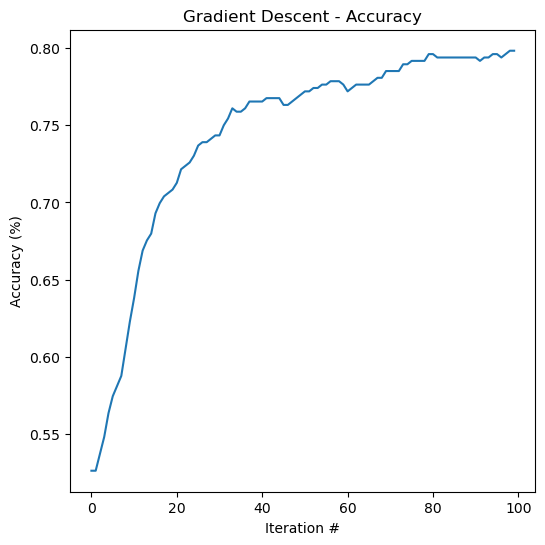

In [72]:
plot_accuracy(accuracy_gd_bc, gd_method, iterations_gd_bc)

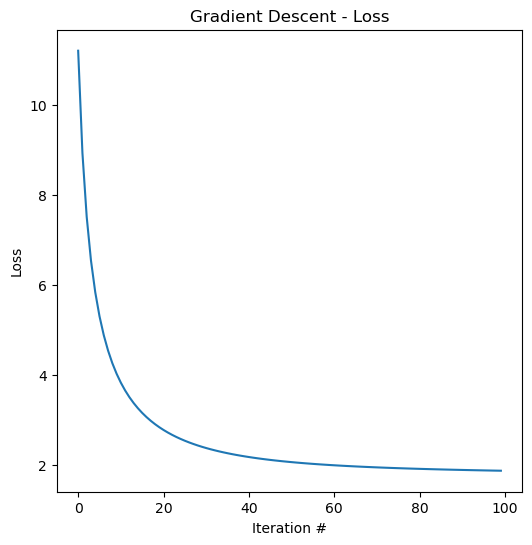

In [73]:
plot_loss(loss_gd_bc, gd_method, iterations_gd_bc)

### BCGD with Randomized Rule

In [74]:
%%time
np.random.seed(42)

bcgd_rr_bc = bcgd_randomized(y_init_bc, y_train_bc, y_test_bc, 
                              w_labeled_unlabeled_bc, w_unlabeled_unlabeled_bc,
                              hessian_bc)

RANDOMIZED GRADIENT DESCENT - Iterations: 45600
----------------------------------------------------------------------
Iteration: 1 -> Loss: 15.7847, Accuracy approximation: 52.41%
Iteration: 2280 -> Loss: 1.3595, Accuracy approximation: 75.22%
Iteration: 4560 -> Loss: 0.8508, Accuracy approximation: 78.29%
Iteration: 6840 -> Loss: 0.7724, Accuracy approximation: 80.04%
Iteration: 9120 -> Loss: 0.7365, Accuracy approximation: 80.48%
Iteration: 11400 -> Loss: 0.7122, Accuracy approximation: 80.92%
Iteration: 13680 -> Loss: 0.7102, Accuracy approximation: 80.92%
Iteration: 15960 -> Loss: 0.7096, Accuracy approximation: 81.14%
Stopping algorithm because of insignificant improvement in the loss.
CPU times: total: 1.44 s
Wall time: 1.74 s


In [75]:
prediction_rr_bc = bcgd_rr_bc[0]
accuracy_rr_bc = bcgd_rr_bc[1]
loss_rr_bc = bcgd_rr_bc[2]
run_time_rr_bc = bcgd_rr_bc[3]
iterations_rr_bc = bcgd_rr_bc[4]

gd_method = "Block Coordinate Gradient Descent with Randomized Rule"

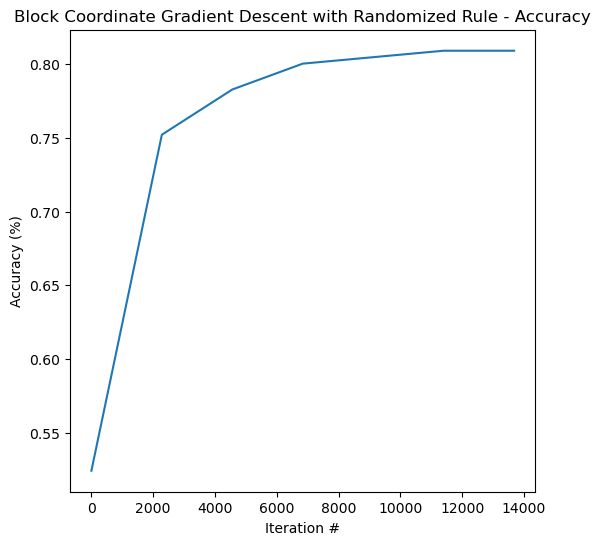

In [76]:
plot_accuracy(accuracy_rr_bc, gd_method, iterations_rr_bc)

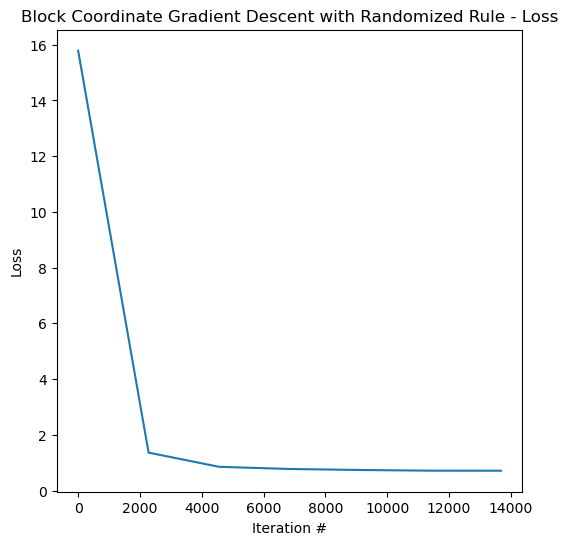

In [77]:
plot_loss(loss_rr_bc, gd_method, iterations_rr_bc)

### BCGD with Gauss-Southwell Scheme


In [78]:
%%time
np.random.seed(42)

bcgd_gs_bc = bcgd_gauss_southwell(y_init_bc, y_train_bc, y_test_bc, 
                                   w_labeled_unlabeled_bc, w_unlabeled_unlabeled_bc,
                                   hessian_bc)

GAUSS-SOUTHWELL GRADIENT DESCENT - Iterations: 45600
 
----------------------------------------------------------------------
Iteration: 1 -> Loss: 15.7847, Accuracy approximation: 52.41%
Iteration: 456 -> Loss: 0.8261, Accuracy approximation: 69.96%
Iteration: 912 -> Loss: 0.7120, Accuracy approximation: 71.71%
Iteration: 1368 -> Loss: 0.7047, Accuracy approximation: 75.22%
Iteration: 1824 -> Loss: 0.7019, Accuracy approximation: 77.19%
Iteration: 2280 -> Loss: 0.7008, Accuracy approximation: 78.07%
Stopping algorithm because of insignificant improvement in the loss.
CPU times: total: 297 ms
Wall time: 494 ms


In [79]:
prediction_gs_bc = bcgd_gs_bc[0]
accuracy_gs_bc = bcgd_gs_bc[1]
loss_gs_bc = bcgd_gs_bc[2]
run_time_gs_bc = bcgd_gs_bc[3]
iterations_gs_bc = bcgd_gs_bc[4]

gd_method = "Block Coordinate Gradient Descent with Gauss-Southwell Scheme"

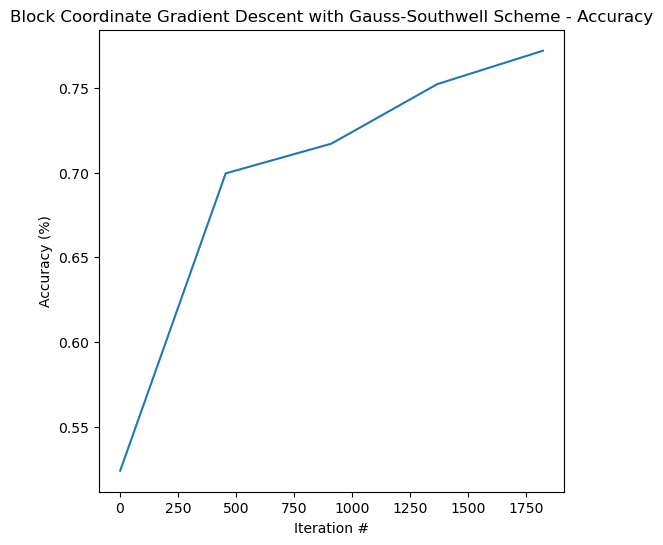

In [80]:
plot_accuracy(accuracy_gs_bc, gd_method, iterations_gs_bc)

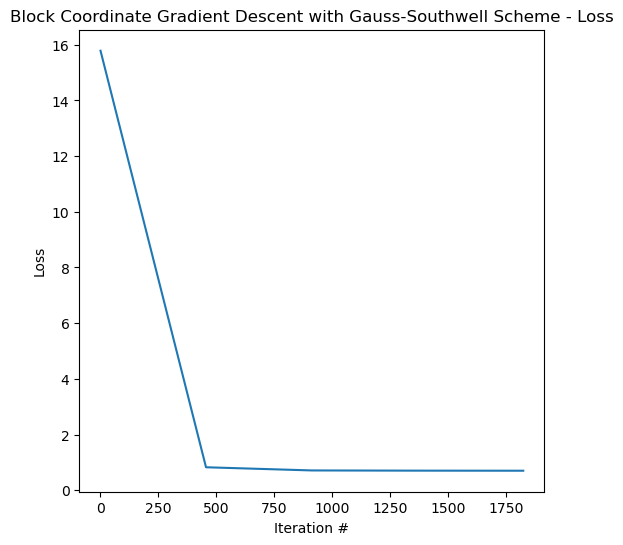

In [81]:
plot_loss(loss_gs_bc, gd_method, iterations_gs_bc)

### Comparison between gradient methods

### Accuracy

#### Accuracy vs CPU time

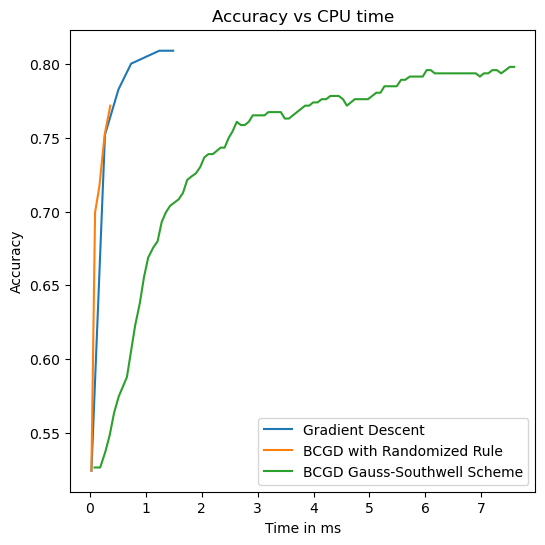

In [128]:
plt.plot(run_time_rr_bc, accuracy_rr_bc)
plt.plot(run_time_gs_bc, accuracy_gs_bc)
plt.plot(run_time_gd_bc, accuracy_gd_bc)

plt.title("Accuracy vs CPU time")
plt.xlabel("Time in ms")
plt.ylabel("Accuracy")
plt.legend(gd_methods)

#### Accuracy vs Iterations

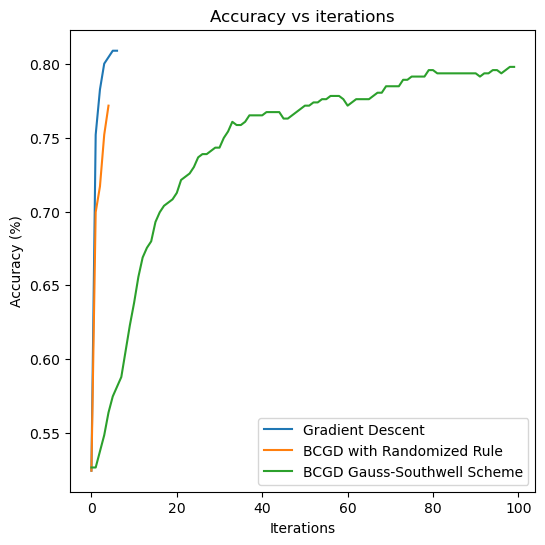

In [129]:
plt.plot(accuracy_rr_bc)
plt.plot(accuracy_gs_bc)
plt.plot(accuracy_gd_bc)

plt.title("Accuracy vs iterations")
plt.xlabel("Iterations")
plt.ylabel("Accuracy (%)")
plt.legend(gd_methods)

### Loss

#### Loss vs CPU time

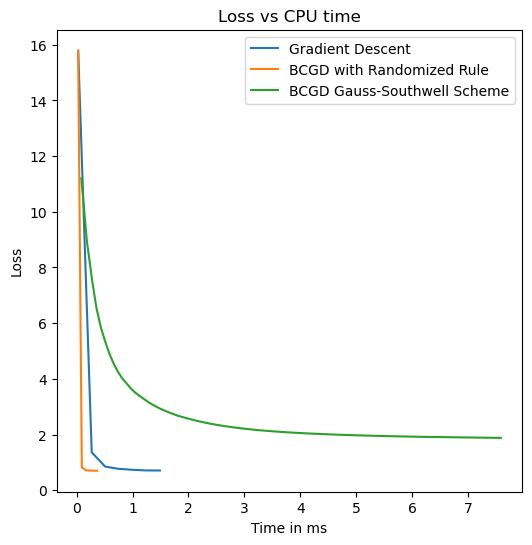

In [130]:
plt.plot(run_time_rr_bc, loss_rr_bc)
plt.plot(run_time_gs_bc, loss_gs_bc)
plt.plot(run_time_gd_bc, loss_gd_bc)

plt.title("Loss vs CPU time")
plt.xlabel("Time in ms")
plt.ylabel("Loss")
plt.legend(gd_methods)

#### Loss vs Iterations

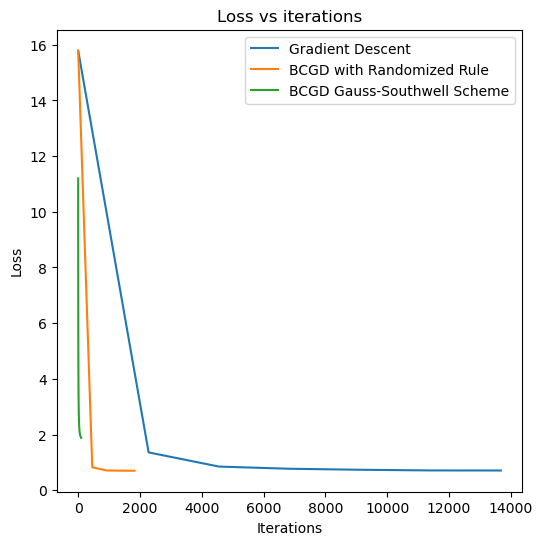

In [131]:
plt.plot(iterations_rr_bc, loss_rr_bc)
plt.plot(iterations_gs_bc, loss_gs_bc)
plt.plot(iterations_gd_bc, loss_gd_bc)


plt.title("Loss vs iterations")
plt.xlabel("Iterations")
plt.ylabel("Loss")
plt.legend(gd_methods)

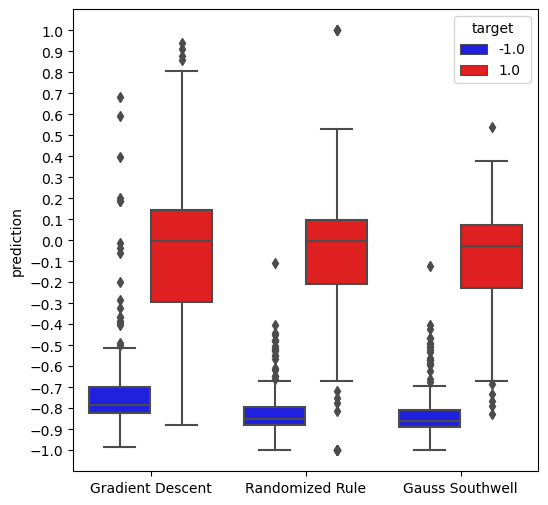

In [86]:
gd_pred_bc = build_predictions_df_boxplot(prediction_gd_bc, y_test_bc, 'Gradient Descent')
rr_pred_bc = build_predictions_df_boxplot(prediction_rr_bc, y_test_bc, 'Randomized Rule')
gs_pred_bc = build_predictions_df_boxplot(prediction_gs_bc, y_test_bc, 'Gauss Southwell')

df_pred = pd.concat([gd_pred_bc, rr_pred_bc, gs_pred_bc])
ax = sns.boxplot(x="gd_method", y="prediction",
            hue="target", palette=["b", "r"],data=df_pred)
ax.set_yticks(np.arange(-1,1.1,0.1))
ax.set(xlabel=None)

plt.show()

## WATER QUALITY DATASET

In [87]:
# load the dataset
wq_url = "C:/Users/inesc/Downloads/waterQuality1.csv"
wq_data = pd.read_csv(wq_url)
wq_df = pd.DataFrame(wq_data)

### Data Preparation


In [88]:
wq_df.shape
wq_df=wq_df[wq_df["ammonia"].str.contains("#NUM")==False]
wq_df.shape

(7996, 21)

In [89]:
wq_df['is_safe'] = np.where(wq_df['is_safe'] =="0", -1, wq_df['is_safe'])

In [90]:
# Splitting the X and Y into the training set and testing set

X_wq = wq_df.iloc[:, 1:20]
y_wq = wq_df.is_safe

X_train_wq, X_test_wq, y_train_wq, y_test_wq = train_test_split(X_wq, y_wq, test_size = 0.90, random_state = 0)

# Use Standard Scaler to standarize the data

std = StandardScaler()

X_train_std_wq = std.fit_transform(X_train_wq)
X_train_std_wq = pd.DataFrame(X_train_std_wq, columns=X_wq.columns)
X_test_std_wq = std.transform(X_test_wq)
X_test_std_wq = pd.DataFrame(X_test_std_wq, columns=X_wq.columns)

pca_wq = PCA().fit(X_train_std_wq)

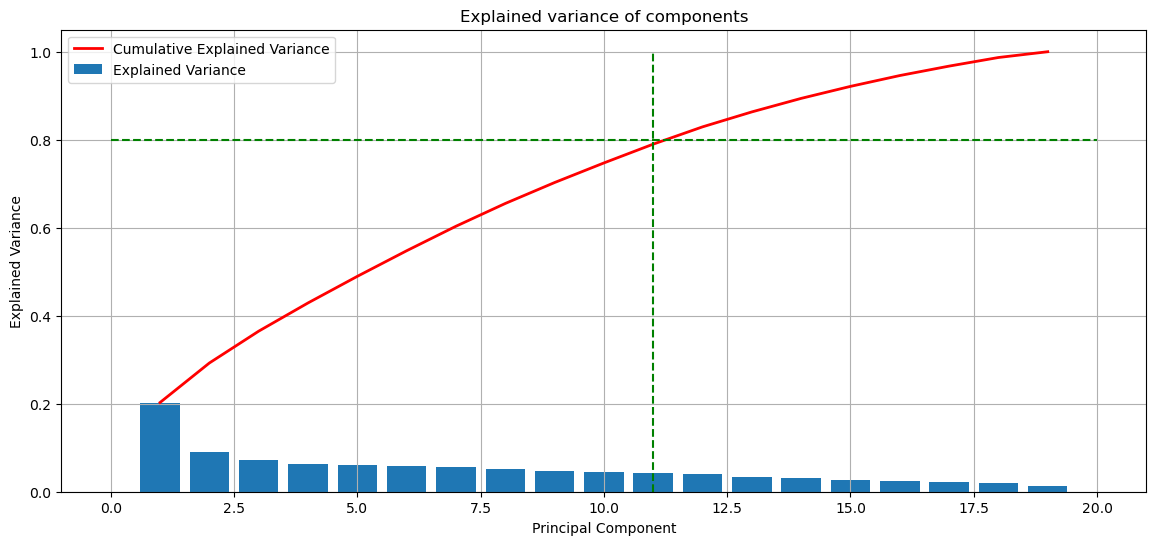

In [149]:
fig, ax = plt.subplots(figsize = (14,6))
x_values = range(1, pca_wq.n_components_+1)
ax.bar(x_values, pca_wq.explained_variance_ratio_, lw=2, label='Explained Variance')
ax.plot(x_values, np.cumsum(pca_wq.explained_variance_ratio_), lw=2, label='Cumulative Explained Variance', color='red')
plt.plot([0,pca_wq.n_components_+1], [0.80,0.80],'g--')
plt.plot([11,11],[0,1], 'g--')
ax.set_title('Explained variance of components')
ax.set_xlabel('Principal Component')
ax.set_ylabel('Explained Variance')
plt.grid()
plt.legend()
plt.show()

In [132]:
#Since the first four components show the most variability, we reduce the dimensions and work on the newly transformed data.

pca_wq_4 = PCA(n_components=11).fit(X_train_std_wq) # use only first 4 principal components

# Transform the standardized training and testing data using the PCA object with only 6 components
X_train_pca_wq = pca_wq_4.transform(X_train_std_wq)
X_test_pca_wq = pca_wq_4.transform(X_test_std_wq)

In [133]:
y_train_wq = np.array(y_train_wq).astype("float64")
y_test_wq = np.array(y_test_wq).astype("float64")

### Weights assignment and Hessian matrix


In [134]:
NUNLABELED = X_test_pca_wq.shape[0]

In [135]:
%%time

w_labeled_unlabeled_wq = weight(X_train_pca_wq, X_test_pca_wq)

CPU times: total: 953 ms
Wall time: 1.08 s


In [136]:
%%time

w_unlabeled_unlabeled_wq = weight(X_test_pca_wq, X_test_pca_wq)

CPU times: total: 10.8 s
Wall time: 1min 28s


In [137]:
%%time

hessian_wq = hessian(w_labeled_unlabeled_wq, w_unlabeled_unlabeled_wq)

CPU times: total: 49 s
Wall time: 51.1 s


### Initial vector $y$

In [138]:
y_init_wq = np.random.choice([-1, 1], size=(NUNLABELED,)).astype("float64")

### Gradient Descent

In [139]:
%%time

gd_wq = gradient_descent(y_init_wq, y_train_wq, y_test_wq, 
                         w_labeled_unlabeled_wq, w_unlabeled_unlabeled_wq,
                         hessian_wq)

GRADIENT DESCENT - Maximum Iterations: 100
----------------------------------------------------------------------
Iteration: 1 -> Loss: 1538.2685, Accuracy approximation: 49.28%
Iteration: 10 -> Loss: 566.7153, Accuracy approximation: 49.60%
Iteration: 20 -> Loss: 234.5078, Accuracy approximation: 53.87%
Iteration: 30 -> Loss: 124.4016, Accuracy approximation: 75.10%
Iteration: 40 -> Loss: 82.2190, Accuracy approximation: 84.67%
Iteration: 50 -> Loss: 63.4635, Accuracy approximation: 87.31%
Iteration: 60 -> Loss: 53.7976, Accuracy approximation: 87.87%
Iteration: 70 -> Loss: 48.1086, Accuracy approximation: 87.95%
Iteration: 80 -> Loss: 44.3825, Accuracy approximation: 87.95%
Iteration: 90 -> Loss: 41.7430, Accuracy approximation: 87.95%
Iteration: 100 -> Loss: 39.7687, Accuracy approximation: 87.95%
CPU times: total: 7min 31s
Wall time: 5min 3s


In [140]:
prediction_gd_wq = gd_wq[0]
accuracy_gd_wq = gd_wq[1]
loss_gd_wq = gd_wq[2]
run_time_gd_wq = gd_wq[3]
iterations_gd_wq = gd_wq[4]

gd_method = "Gradient Descent"

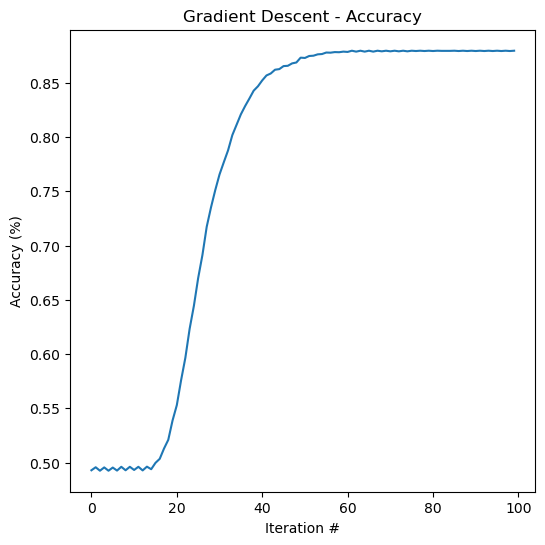

In [141]:
plot_accuracy(accuracy_gd_wq, gd_method, iterations_gd_wq)

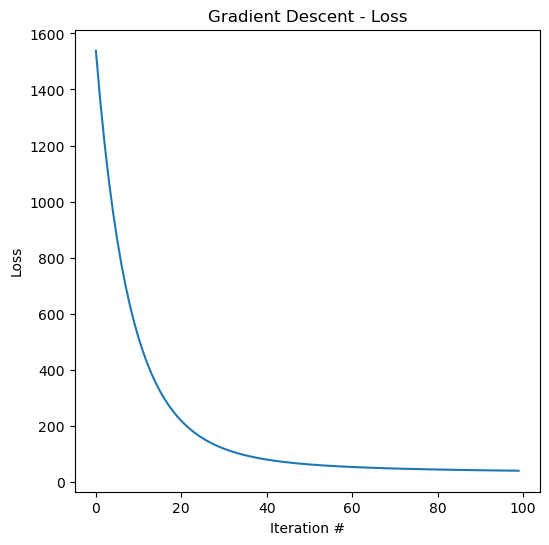

In [142]:
plot_loss(loss_gd_wq, gd_method, iterations_gd_wq)

### BCGD with Randomized Rule

In [143]:
%%time

bcgd_rr_wq = bcgd_randomized(y_init_wq, y_train_wq, y_test_wq, 
                             w_labeled_unlabeled_wq, w_unlabeled_unlabeled_wq,
                             hessian_wq)

RANDOMIZED GRADIENT DESCENT - Iterations: 719700
----------------------------------------------------------------------
Iteration: 1 -> Loss: 1935.5547, Accuracy approximation: 49.76%
Iteration: 35985 -> Loss: 154.0096, Accuracy approximation: 76.57%
Iteration: 71970 -> Loss: 71.2920, Accuracy approximation: 85.33%
Iteration: 107955 -> Loss: 49.8918, Accuracy approximation: 87.24%
Iteration: 143940 -> Loss: 42.0736, Accuracy approximation: 87.63%
Iteration: 179925 -> Loss: 38.4373, Accuracy approximation: 87.80%
Iteration: 215910 -> Loss: 36.0953, Accuracy approximation: 87.88%
Iteration: 251895 -> Loss: 34.4409, Accuracy approximation: 87.93%
Iteration: 287880 -> Loss: 33.5061, Accuracy approximation: 87.94%
Iteration: 323865 -> Loss: 32.8217, Accuracy approximation: 87.94%
Iteration: 359850 -> Loss: 32.3435, Accuracy approximation: 87.94%
Iteration: 395835 -> Loss: 31.9030, Accuracy approximation: 87.95%
Iteration: 431820 -> Loss: 31.6589, Accuracy approximation: 87.95%
Iteration: 46

In [144]:
prediction_rr_wq = bcgd_rr_wq[0]
accuracy_rr_wq = bcgd_rr_wq[1]
loss_rr_wq = bcgd_rr_wq[2]
run_time_rr_wq = bcgd_rr_wq[3]
iterations_rr_wq = bcgd_rr_wq[4]

gd_method = "Block Coordinate Gradient Descent with Randomized Rule"

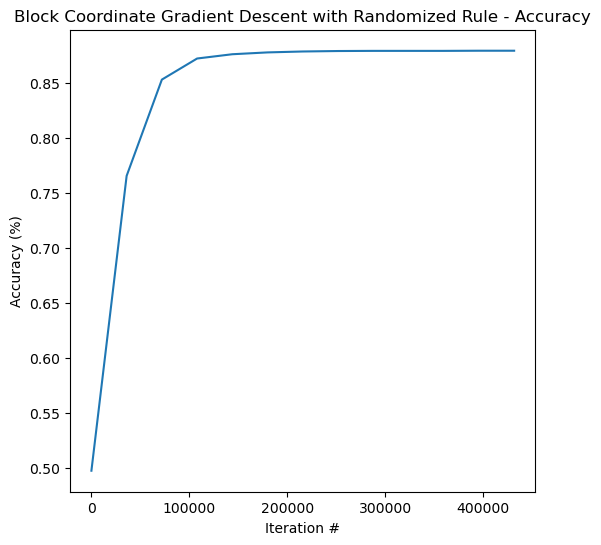

In [145]:
plot_accuracy(accuracy_rr_wq, gd_method, iterations_rr_wq)

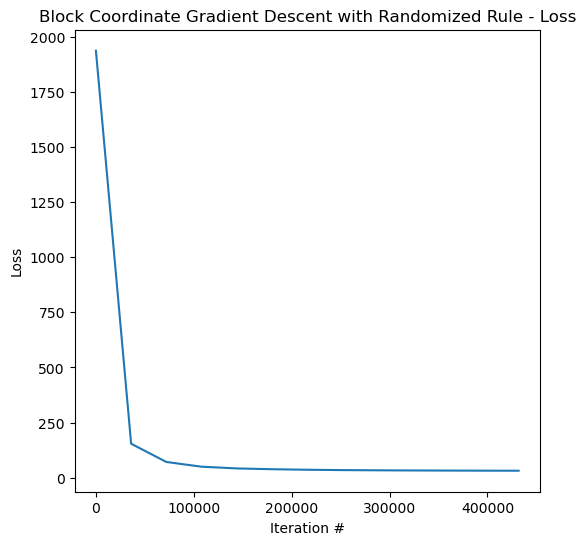

In [146]:
plot_loss(loss_rr_wq, gd_method, iterations_rr_wq)

### BCGD with Gauss-Southwell Scheme


In [147]:
%%time

bcgd_gs_wq = bcgd_gauss_southwell(y_init_wq, y_train_wq, y_test_wq, 
                                  w_labeled_unlabeled_wq, w_unlabeled_unlabeled_wq,
                                  hessian_wq)

GAUSS-SOUTHWELL GRADIENT DESCENT - Iterations: 719700
 
----------------------------------------------------------------------
Iteration: 1 -> Loss: 1935.5314, Accuracy approximation: 49.73%
Iteration: 7197 -> Loss: 86.8078, Accuracy approximation: 87.04%
Iteration: 14394 -> Loss: 39.7057, Accuracy approximation: 87.95%
Iteration: 21591 -> Loss: 34.2240, Accuracy approximation: 87.95%
Iteration: 28788 -> Loss: 32.5170, Accuracy approximation: 87.95%
Iteration: 35985 -> Loss: 32.0877, Accuracy approximation: 87.95%
Iteration: 43182 -> Loss: 31.8348, Accuracy approximation: 87.95%
Iteration: 50379 -> Loss: 31.6812, Accuracy approximation: 87.95%
Stopping algorithm because of insignificant improvement in the loss.
CPU times: total: 27.5 s
Wall time: 37.3 s


In [109]:
prediction_gs_wq = bcgd_gs_wq[0]
accuracy_gs_wq = bcgd_gs_wq[1]
loss_gs_wq = bcgd_gs_wq[2]
run_time_gs_wq = bcgd_gs_wq[3]
iterations_gs_wq = bcgd_gs_wq[4]

gd_method = "Block Coordinate Gradient Descent with Gauss-Southwell Scheme"

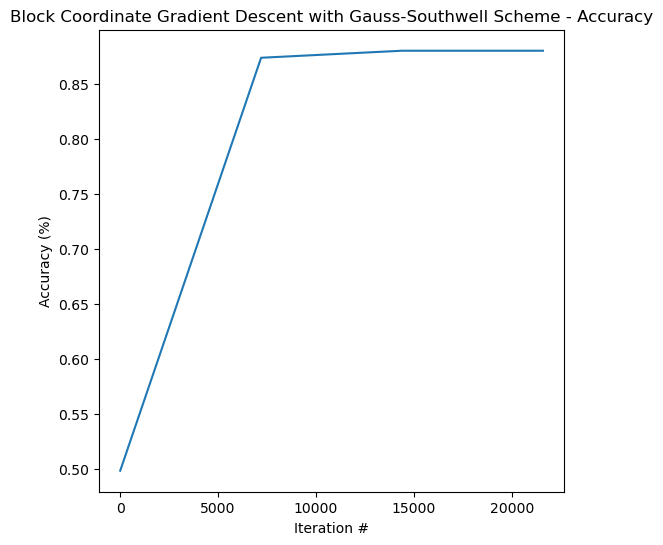

In [110]:
plot_accuracy(accuracy_gs_wq, gd_method, iterations_gs_wq)

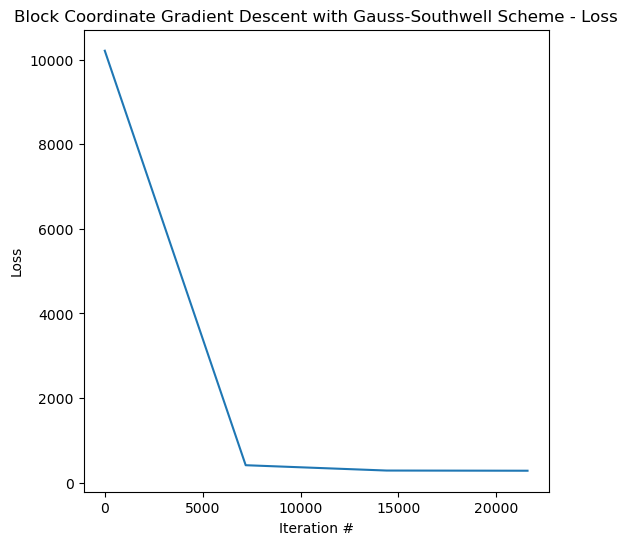

In [111]:
plot_loss(loss_gs_wq, gd_method, iterations_gs_wq)

### Comparison between gradient methods

### Accuracy

#### Accuracy vs CPU time

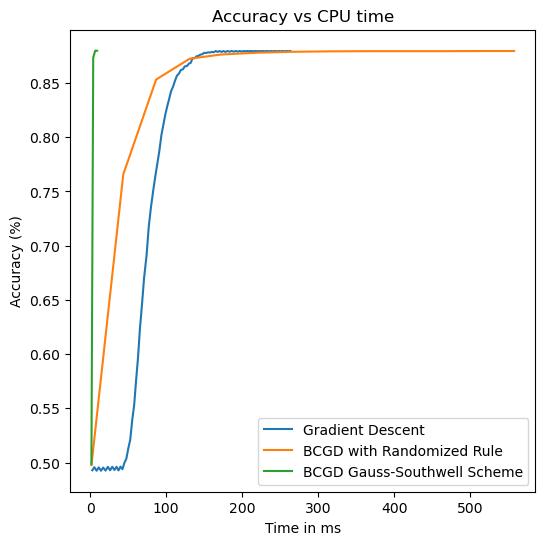

In [150]:
plt.plot(run_time_gd_wq, accuracy_gd_wq)
plt.plot(run_time_rr_wq, accuracy_rr_wq)
plt.plot(run_time_gs_wq, accuracy_gs_wq)

plt.title("Accuracy vs CPU time")
plt.xlabel("Time in ms")
plt.ylabel("Accuracy (%)")

plt.legend(gd_methods)

#### Accuracy vs Iterations

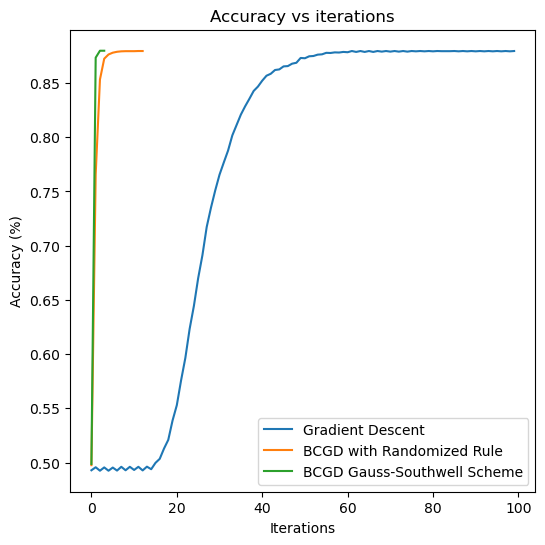

In [151]:
plt.plot(accuracy_gd_wq)
plt.plot(accuracy_rr_wq)
plt.plot(accuracy_gs_wq)

plt.title("Accuracy vs iterations")
plt.xlabel("Iterations")
plt.ylabel("Accuracy (%)")

plt.legend(gd_methods)

### Loss

#### Loss vs CPU time

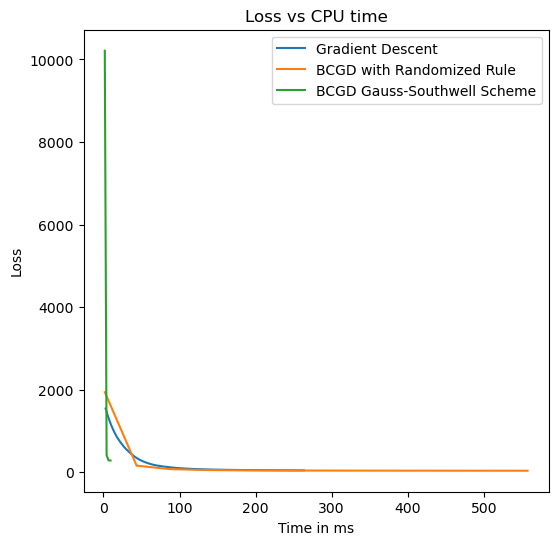

In [152]:
plt.plot(run_time_gd_wq , loss_gd_wq)
plt.plot(run_time_rr_wq , loss_rr_wq)
plt.plot(run_time_gs_wq , loss_gs_wq)

plt.title("Loss vs CPU time")
plt.xlabel("Time in ms")
plt.ylabel("Loss")

plt.legend(gd_methods)

#### Loss vs Iterations

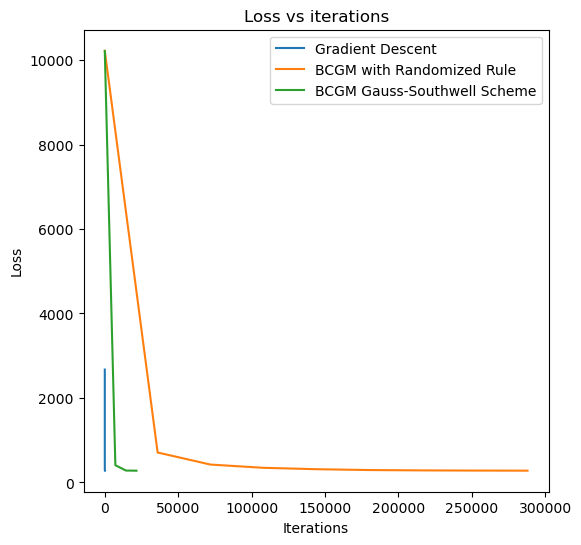

In [115]:
plt.plot(iterations_gd_wq, loss_gd_wq)
plt.plot(iterations_rr_wq, loss_rr_wq)
plt.plot(iterations_gs_wq, loss_gs_wq)

plt.title("Loss vs iterations")
plt.xlabel("Iterations")
plt.ylabel("Loss")

plt.legend(gd_methods)

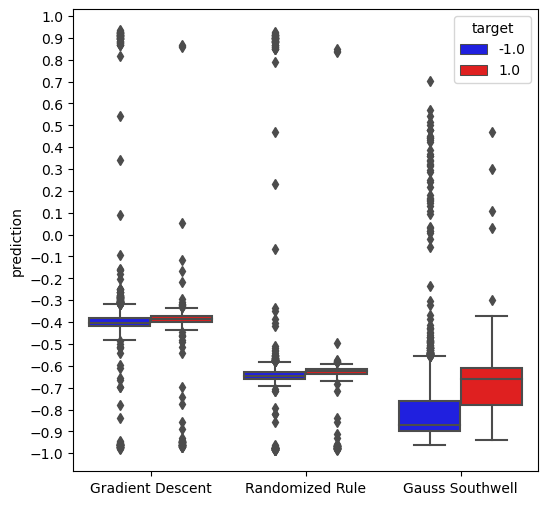

In [153]:
gd_pred_wq = build_predictions_df_boxplot(prediction_gd_wq, y_test_wq, 'Gradient Descent')
rr_pred_wq = build_predictions_df_boxplot(prediction_rr_wq, y_test_wq, 'Randomized Rule')
gs_pred_wq = build_predictions_df_boxplot(prediction_gs_wq, y_test_wq, 'Gauss Southwell')

df_pred = pd.concat([gd_pred_wq, rr_pred_wq, gs_pred_wq])
ax = sns.boxplot(x="gd_method", y="prediction",
            hue="target", palette=["b", "r"],data=df_pred)
ax.set_yticks(np.arange(-1,1.1,0.1))
ax.set(xlabel=None)

plt.show()